# Constraint-satisfaction problems
A large number of problems that computational tools are used to solve can be broadly categorized as constraint-satisfaction problems (CSPs). CSPs are composed of variables with possible values that fall into ranges known as domains. Constraints between the variables must be satisfied in order for constraint-satisfaction problems to be solved. Those three core concepts—variables, domains, and constraints—are simple to understand, and their generality underlies the wide applicability of constraint-satisfaction problem solving.

Constraints will be defined using a Constraint class. Each Constraint consists of the variables it constrains and a method that checks whether it is satisfied(). The determination of whether a constraint is satisfied is the main logic that goes into defining a specific constraint-satisfaction problem. The default implementation should be overridden. In fact, it must be, because we are defining our Constraint class as an abstract base class. Abstract base classes are not meant to be instantiated. Instead, only their subclasses that override and implement their @abstractmethods are for actual use. 

In [1]:
from typing import Generic, TypeVar, Dict, List, Optional
from abc import ABC, abstractmethod
import pprint
pp = pprint.PrettyPrinter(indent=2)

V = TypeVar('V') # variable type
D = TypeVar('D') # domain type

# Base class for all constraints
class Constraint(Generic[V, D], ABC):
    # The variables that the constraint is between
    def __init__(self, variables: List[V]) -> None:
        self.variables = variables


    # Must be overridden by subclasses
    @abstractmethod
    def satisfied(self, assignment: Dict[V, D]) -> bool:
        ...

The centerpiece of our constraint-satisfaction framework will be a class called CSP. CSP is the gathering point for variables, domains, and constraints. In terms of its type hints, it uses generics to make itself flexible enough to work with any kind of variables and domain values (V keys and D domain values). 

In [2]:
# A constraint satisfaction problem consists of variables of type V
# that have ranges of values known as domains of type D and constraints
# that determine whether a particular variable's domain selection is valid
class CSP(Generic[V, D]):
    def __init__(self, variables: List[V], domains: Dict[V, List[D]]) -> None:
        self.variables: List[V] = variables # variables to be constrained
        self.domains: Dict[V, List[D]] = domains # domain of each variable
        self.constraints: Dict[V, List[Constraint[V, D]]] = {}
        for variable in self.variables:
            self.constraints[variable] = []
            if variable not in self.domains:
                raise LookupError("Every variable should have a domain assigned to it: {}")

    def add_constraint(self, constraint: Constraint[V, D]) -> None:
        for variable in constraint.variables:
            if variable not in self.variables:
                raise LookupError("Variable in constraint not in CSP")
            else:
                self.constraints[variable].append(constraint)
                
    # Check if the value assignment is consistent by checking all constraints
    # for the given variable against it
    def consistent(self, variable: V, assignment: Dict[V, D]) -> bool:
        for constraint in self.constraints[variable]:
            if not constraint.satisfied(assignment):
                return False
        return True
    
    # This constraint-satisfaction framework will use a simple backtracking search to find 
    # solutions to problems. Backtracking is the idea that once you hit a wall in your search, 
    # you go back to the last known point where you made a decision before the wall, and choose a different path. 
    def backtracking_search(self, assignment: Dict[V, D] = {}) -> Optional[Dict[V, D]]:
        # assignment is complete if every variable is assigned (our base case)
        if len(assignment) == len(self.variables):
            return assignment

        # get all variables in the CSP but not in the assignment
        unassigned: List[V] = [v for v in self.variables if v not in assignment]

        # get the every possible domain value of the first unassigned variable
        first: V = unassigned[0]
        for value in self.domains[first]:
            local_assignment = assignment.copy()
            local_assignment[first] = value
            # if we're still consistent, we recurse (continue)
            if self.consistent(first, local_assignment):
                result: Optional[Dict[V, D]] = self.backtracking_search(local_assignment)
                # if we didn't find the result, we will end up backtracking
                if result is not None:
                    return result
        return None

## Map-Coloring Problem
Imagine you have a map of Australia that you want to color by state/territory. No two adjacent regions should share a color. Can you color the regions with just three different colors? It is a trivial problem, really, and a great first problem for our backtracking constraint-satisfaction solver.

To model the problem as a CSP, we need to define the variables, domains, and constraints. The variables are the seven regions of Australia. In our CSP, they can be modeled with strings. The domain of each variable is the three different colors that can possibly be assigned. The constraints are the tricky part. No two adjacent regions can be colored with the same color, so our constraints will be dependent on which regions border one another. We can use what are called binary constraints (constraints between two variables). Every two regions that share a border will also share a binary constraint indicating that they cannot be assigned the same color. 

To implement these binary constraints in code, we need to subclass the Constraint class. The MapColoringConstraint subclass will take two variables in its constructor: the two regions that share a border. Its overridden satisfied() method will check first whether the two regions have domain values assigned to them; if either does not, the constraint is trivially satisfied until they do. (There cannot be a conflict when one does not yet have a color.) Then it will check whether the two regions are assigned the same color. Obviously, there is a conflict, meaning that the constraint is not satisfied, when they are the same. 

In [3]:
from typing import Dict, List, Optional

class MapColoringConstraint(Constraint[str, str]):
    def __init__(self, place1: str, place2: str) -> None:
        super().__init__([place1, place2])
        self.place1: str = place1
        self.place2: str = place2

    def satisfied(self, assignment: Dict[str, str]) -> bool:
        # If either place is not in the assignment, then it is not
        # yet possible for their colors to be conflicting
        if self.place1 not in assignment or self.place2 not in assignment:
            return True
        # check the color assigned to place1 is not the same as the
        # color assigned to place2
        return assignment[self.place1] != assignment[self.place2]

Now that we have a way of implementing the constraints between regions, fleshing out the Australian map-coloring problem with our CSP solver is simply a matter of filling in domains and variables, and then adding constraints. 

In [4]:
variables: List[str] = ["Western Australia", "Northern Territory", "South Australia", "Queensland", 
                        "New South Wales", "Victoria", "Tasmania"]
domains: Dict[str, List[str]] = {}
for variable in variables:
    domains[variable] = ["red", "green", "blue"]

csp: CSP[str, str] = CSP(variables, domains)
csp.add_constraint(MapColoringConstraint("Western Australia", "Northern Territory"))
csp.add_constraint(MapColoringConstraint("Western Australia", "South Australia"))
csp.add_constraint(MapColoringConstraint("South Australia", "Northern Territory"))
csp.add_constraint(MapColoringConstraint("Queensland", "Northern Territory"))
csp.add_constraint(MapColoringConstraint("Queensland", "South Australia"))
csp.add_constraint(MapColoringConstraint("Queensland", "New South Wales"))
csp.add_constraint(MapColoringConstraint("New South Wales", "South Australia"))
csp.add_constraint(MapColoringConstraint("Victoria", "South Australia"))
csp.add_constraint(MapColoringConstraint("Victoria", "New South Wales"))
csp.add_constraint(MapColoringConstraint("Victoria", "Tasmania"))

solution: Optional[Dict[str, str]] = csp.backtracking_search()
if solution is None:
    print("No solution found!")
else:
    pp.pprint(solution)

{ 'New South Wales': 'green',
  'Northern Territory': 'green',
  'Queensland': 'red',
  'South Australia': 'blue',
  'Tasmania': 'green',
  'Victoria': 'red',
  'Western Australia': 'red'}


## The eight queens problem 
A chessboard is an eight-by-eight grid of squares. A queen is a chess piece that can move on the chessboard any number of squares along any row, column, or diagonal. A queen is attacking another piece if in a single move, it can move to the square the piece is on without jumping over any other piece. The eight queens problem poses the question of how eight queens can be placed on a chessboard without any queen attacking another queen.

To represent squares on the chessboard, we will assign each an integer row and an integer column. We can ensure each of the eight queens is not on the same column by simply assigning them sequentially the columns 1 through 8. The variables in our constraint-satisfaction problem can just be the column of the queen in question. The domains can be the possible rows (again, 1 through 8).

To solve the problem, we will need a constraint that checks whether any two queens are on the same row or diagonal. (They were all assigned different sequential columns to begin with.) Checking for the same row is trivial, but checking for the same diagonal requires a little bit of math. If any two queens are on the same diagonal, the difference between their rows will be the same as the difference between their columns.

In [5]:
from typing import Dict, List, Optional

class QueensConstraint(Constraint[int, int]):
    def __init__(self, columns: List[int]) -> None:
        super().__init__(columns)
        self.columns: List[int] = columns

    def satisfied(self, assignment: Dict[int, int]) -> bool:
       # q1c = queen 1 column, q1r = queen 1 row
        for q1c, q1r in assignment.items(): 
        # q2c = queen 2 column
            for q2c in range(q1c + 1, len(self.columns) + 1): 
                if q2c in assignment:
                    q2r: int = assignment[q2c] # q2r = queen 2 row
                    if q1r == q2r: # same row?
                        return False
                    if abs(q1r - q2r) == abs(q1c - q2c): # same diagonal?
                        return False
        return True # no conflict

# run the search
columns: List[int] = [1, 2, 3, 4, 5, 6, 7, 8]
rows: Dict[int, List[int]] = {}
for column in columns:
    rows[column] = [1, 2, 3, 4, 5, 6, 7, 8]
    
csp: CSP[int, int] = CSP(columns, rows)
csp.add_constraint(QueensConstraint(columns))
solution: Optional[Dict[int, int]] = csp.backtracking_search()
if solution is None:
    print("No solution found!")
else:
    print(solution)

{1: 1, 2: 5, 3: 8, 4: 6, 5: 3, 6: 7, 7: 2, 8: 4}


## Word search
A word search is a grid of letters with hidden words placed along rows, columns, and diagonals. A player of a word-search puzzle attempts to find the hidden words by carefully scanning through the grid. Finding places to put the words so that they all fit on the grid is a kind of constraint-satisfaction problem. The variables are the words, and the domains are the possible locations of those words.

The grid of this word-search problem is not entirely dissimilar from the mazes of chapter 2.

In [6]:
from typing import NamedTuple, List, Dict, Optional
from random import choice
from string import ascii_uppercase

Grid = List[List[str]]  # type alias for grids


class Location(NamedTuple):
    row: int
    column: int
              

def generate_grid(rows: int, columns: int) -> Grid:
    # initialize grid with random letters
    return [[choice(ascii_uppercase) for c in range(columns)] for r in
     range(rows)]

def display_grid(grid: Grid) -> None:
    for row in grid:
        print("".join(row))

To figure out where words can fit in the grid, we will generate their domains. The domain of a word is a list of lists of the possible locations of all of its letters. Words cannot just go anywhere, though. They must stay within a row, column, or diagonal that is within the bounds of the grid. In other words, they should not go off the end of the grid.

In [7]:
def generate_domain(word: str, grid: Grid) -> List[List[Location]]:
    domain: List[List[Locat:ion]] = []
    height: int = len(grid)
    width: int = len(grid[0])
    length: int = len(word)
    for row in range(height):
        for col in range(width):
            columns: range = range(col, col + length + 1)
            rows: range = range(row, row + length + 1)
            if col + length <= width:
                # left to right
                domain.append([Location(row, c) for c in columns])
                # diagonal towards bottom right
                if row + length <= height:
                    domain.append([Location(r, col + (r - row)) for r in rows])
            if row + length <= height:
                # top to bottom
                domain.append([Location(r, col) for r in rows])
                # diagonal towards bottom left
                if col - length >= 0:
                    domain.append([Location(r, col - (r - row)) for r in rows])
    return domain

The satisfied() method of WordSearchConstraint simply checks whether any of the locations proposed for one word are the same as a location proposed for another word. It does this using a set. Converting a list into a set will remove all duplicates. If there are fewer items in a set converted from a list than there were in the original list, that means the original list contained some duplicates.

In [8]:
class WordSearchConstraint(Constraint[str, List[Location]]):
    def __init__(self, words: List[str]) -> None:
        super().__init__(words)
        self.words: List[str] = words

    def satisfied(self, assignment: Dict[str, List[Location]]) -> bool:
        # if there are any duplicates grid locations, then there is an overlap
        all_locations = [locs for values in assignment.values() for locs in values]
        return len(set(all_locations)) == len(all_locations)

In [9]:
grid: Grid = generate_grid(9, 9)
words: List[str] = ["MATTHEW", "JOE", "MARY", "SARAH", "SALLY"]
locations: Dict[str, List[List[Location]]] = {}
for word in words:
    locations[word] = generate_domain(word, grid)

csp: CSP[str, List[Location]] = CSP(words, locations)
csp.add_constraint(WordSearchConstraint(words))

solution: Optional[Dict[str, List[Location]]] = csp.backtracking_search()
if solution is None:
    print("No solution found!")
else:
    print("========== solution ==========")
    for word, grid_locations in solution.items():
        print(word)
        pp.pprint(grid_locations)
        for index, letter in enumerate(word):
            (row, col) = (grid_locations[index].row, grid_locations[index].column)
            grid[row][col] = letter 
    print("========== solution ==========")
    display_grid(grid)

========== solution ==========
MATTHEW
[ Location(row=0, column=0),
  Location(row=0, column=1),
  Location(row=0, column=2),
  Location(row=0, column=3),
  Location(row=0, column=4),
  Location(row=0, column=5),
  Location(row=0, column=6),
  Location(row=0, column=7)]
JOE
[ Location(row=0, column=8),
  Location(row=1, column=8),
  Location(row=2, column=8),
  Location(row=3, column=8)]
MARY
[ Location(row=1, column=0),
  Location(row=1, column=1),
  Location(row=1, column=2),
  Location(row=1, column=3),
  Location(row=1, column=4)]
SARAH
[ Location(row=1, column=5),
  Location(row=2, column=5),
  Location(row=3, column=5),
  Location(row=4, column=5),
  Location(row=5, column=5),
  Location(row=6, column=5)]
SALLY
[ Location(row=1, column=6),
  Location(row=2, column=6),
  Location(row=3, column=6),
  Location(row=4, column=6),
  Location(row=5, column=6),
  Location(row=6, column=6)]
========== solution ==========
MATTHEWRJ
MARYPSSEO
ASCJGAAWE
TFZFMRLNX
RMUDOALVE
VFBGVHYXC
XXDJBNBU

## Circuit board layout
A manufacturer needs to fit certain rectangular chips onto a rectangular circuit board. Essentially, this problem asks, “How can several different-sized rectangles all fit snugly inside of another rectangle?”

The circuit board layout problem is similar to the word-search problem. Instead of 1×N rectangles (words), the problem presents M×N rectangles. Like in the word-search problem, the rectangles cannot overlap. The rectangles cannot be put on diagonals, so in that sense the problem is actually simpler than the word search. 

In [10]:
class CircuitBoard(NamedTuple):
    color: str
    width: int
    height: int
        
    def generate_board(self, width: int, height: int) -> [Location]:
        board = []
        for col in range(width - self.width + 1):
            for row in range(height - self.height + 1):
                loc = Location(col, row)
                board.append(loc)
        return board

We create a class for a rectangle that provides a method to check if two rectangles intersects.

In [11]:
class Point():
    x = None
    y = None

    def __init__(self, x, y):
        self.x, self.y = x, y

    def __str__(self):
        return "({},{})".format(self.x, self.y)


class Rect:
    def __init__(self, x: int, y: int, width: int, height: int):
        self.l_top  = Point(x, y)
        self.r_top  = Point(x+width, y)
        self.r_bot  = Point(x+width, y+height)
        self.l_bot  = Point(x, y+height)
        self.width = width
        self.height = height
    
    def intersects(self, r):
        tw = self.width
        th = self.height
        rw = r.width
        rh = r.height
        if (rw <= 0 or rh <= 0 or tw <= 0 or th <= 0):
            return False
        
        tx = self.l_top.x
        ty = self.l_top.y
        rx = r.l_top.x
        ry = r.l_top.y
        rw += rx
        rh += ry
        tw += tx
        th += ty
        #      overflow || intersect
        return ((rw < rx or rw > tx) and
                (rh < ry or rh > ty) and
                (tw < tx or tw > rx) and
                (th < ty or th > ry))

    #for debugging purpose
    def __str__(self):
        return "{},{};{},{}".format(self.l_top, self.r_top, self.r_bot, self.l_bot)

In [12]:
class CircuitBoardConstraint(Constraint[CircuitBoard, Location]):
    def __init__(self, left: CircuitBoard, right: CircuitBoard) -> None:
        super().__init__([left, right])
        self.left: CircuitBoad = left
        self.right: CircuitBoad = right
            
    def satisfied(self, assignment: Dict[CircuitBoard, Location]) -> bool:
        var1 = assignment.get(self.left)
        var2 = assignment.get(self.right)
        if var1 == None or var2 == None:
            return True
        #check that left does not overlap right
        rect1 = Rect(var1.column, var1.row, self.left.width, self.left.height)
        rect2 = Rect(var2.column, var2.row, self.right.width, self.right.height)
        intersects = rect1.intersects(rect2)
        #print("{} - {} => {}".format(rect1, rect2, intersects))
        return not intersects

In [13]:
#plots the items of the solution
def plot_solution(items):
    %matplotlib inline
    import matplotlib
    import matplotlib.pyplot as plt

    plt.title("circuit board")
    plt.xlabel("column")
    plt.ylabel("row")
    plt.grid(True)

    for board, location in items:
        x = location.column
        y = location.row
        rectangle = plt.Rectangle((x, y), board.width, board.height, fc=board.color)
        plt.gca().add_patch(rectangle)

    plt.axis('scaled')
    plt.show()

Prepare variables and domains.

In [14]:
board_width = 20
board_height = 20

variables: [CircuitBoard] = [CircuitBoard("red",10,10),
                             CircuitBoard("brown",8,4),
                             CircuitBoard("blue",5,5),
                             CircuitBoard("yellow",2,2),
                             CircuitBoard("green",5,10),
                             CircuitBoard("pink",4,4),
                             CircuitBoard("orange",6,6)]
    
domains: Dict[CircuitBoard, Location] = {}
for variable in variables:
    domains[variable] = variable.generate_board(board_width, board_height)
    
csp: CSP[CircuitBoard, List[Location]] = CSP(variables, domains)

l: int = len(variables)
for i in range(0, l):
    for j in range(i+1, l):
        csp.add_constraint(CircuitBoardConstraint(variables[i], variables[j]))

Find a possible solution with back tracking search algorithm.

CircuitBoard(color='red', width=10, height=10) => Location(row=0, column=0)
CircuitBoard(color='brown', width=8, height=4) => Location(row=0, column=10)
CircuitBoard(color='blue', width=5, height=5) => Location(row=4, column=10)
CircuitBoard(color='yellow', width=2, height=2) => Location(row=0, column=18)
CircuitBoard(color='green', width=5, height=10) => Location(row=9, column=10)
CircuitBoard(color='pink', width=4, height=4) => Location(row=4, column=15)
CircuitBoard(color='orange', width=6, height=6) => Location(row=10, column=0)


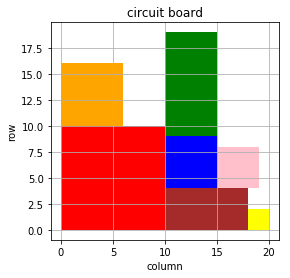

In [15]:
solution: Optional[Dict[CircuitBoard, List[Location]]] = csp.backtracking_search()
    
if solution is None:
    print("No solution found!")
else:
    items = solution.items()
    
    for board, location in items:
        print("{} => {}".format(board, location)) 
        
    plot_solution(items)